In [1]:
from rnn_vanilla import *
from torch.distributions import Categorical

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Read the file
f = open('data/train.txt', 'r')
content = f.read()

# Get the unique character dictionary 
unique_chars = set(content)
unique_chars.add('λ')
chars_lst = sorted(list(unique_chars), key=str)
char_dict = {char:i for i, char in enumerate(chars_lst, 0)}
char_idxs = {i:char for i, char in enumerate(chars_lst, 0)}

# One hot Encoding
length = len(chars_lst)
onehot = np.zeros((length, length))
for i, char in enumerate(chars_lst, 0):
    onehot[i, i] = 1

In [3]:
# Helper functions

# Replace the the character in each music text file with integers
def prepare(sample):   
    return torch.LongTensor([[char_dict[i] for i in sample]])

# Get the chunk for the song inputted 
def get_chunks(song):
    chunklst = []
    C = 100 #chunk size
    chunks = len(song) // C

    for idx in range(chunks):
        i = idx * C
        j = (idx + 1) * C
        inp = prepare(song[i:j])
        tar = prepare(song[i + 1:j + 1])
        chunklst.append((inp, tar))
    return chunklst

# Transform from tensor to character of the music
def tensor_to_char(sample):
    return ''.join(char_idxs[i.item()] for i in sample.to('cpu'))

def to_char(sample):
    return char_idxs[sample.item()]

In [4]:
# Initialize with the following configurations
HIDDEN_SIZE = 100
INPUT_SIZE = 94
OUTPUT_SIZE = 94

#Initialize the weight
weight = torch.Tensor(onehot)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = RNnet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, weight).to(device)
criterion = nn.CrossEntropyLoss()

#Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(net.parameters(), lr=0.001)

net

RNnet(
  (char_embeddings): Embedding(94, 94)
  (rnn): RNN(94, 100)
  (hidden2out): Linear(in_features=100, out_features=94, bias=True)
)

In [8]:
# Load the training and validation set 
trainset = loader('data/train.txt')
validset = loader('data/val.txt')

valid = DataLoader(validset, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)
train = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

In [9]:
# Training data and get validation losses
states = None
epochs = 25
N = 50
stop = True #ESing
tloss = []
vloss = []
models = []

for itrs in range(epochs):
    
    epochloss = []
    states = None
    
    for i, song in enumerate(train, 0):
        song = song[0]
        trainloss = 0
        minibatchloss = 0
        xnloss = []
        states = None
        
        for inputs, targets in get_chunks(song):
            
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = net(inputs, states)
            targs = torch.squeeze(targets)
            print('Epoch [%d] minibatch [%d]\r' % (itrs+1, i), end="")

            loss = criterion(outputs, targs)
            loss.backward()
            optimizer.step()

            trainloss += loss.item()      
            xnloss.append(loss.item())

            if i % N == 49:
#                 trainloss /= N
                #Print the loss averaged over the last N mini-batches
                print('\tEpoch %d, running %d loss: %.3f\r' % (1,i+1, trainloss), end="")
                trainloss = 0

        song_loss = np.average(xnloss)
        epochloss.append(song_loss)
    
    eploss = np.average(epochloss)
                
    print('Epoch [%d] train loss is (%.3f)' % (itrs+1, eploss)) 
    tloss.append(eploss)
    
    
    epochloss = []
    
    with torch.no_grad():
        for i, song in enumerate(valid, 0):
            song = song[0]
            validloss = 0
            minibatchloss = 0
            xncost = []
            states = None
            for inputs, targets in get_chunks(song):
            
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = net(inputs, states)

                targs = torch.squeeze(targets)
    #             print('Epoch [%d] minibatch [%d]\r' % (itrs+1, i), end="")
                loss = criterion(outputs, targs).item()

                validloss += loss

                xncost.append(loss)

                if i % N == 49:
                    validloss /= N
                    #Print the loss averaged over the last N mini-batches
                    print('\tEpoch %d, valid %d loss: %.3f\r' % (1,i+1, validloss), end="")
                    validloss = 0
            
            
            eploss = np.average(xncost)
            epochloss.append(eploss)
    
        ep_loss = np.average(epochloss)
        print('Epoch [%d] valid loss is (%.3f)' % (itrs+1, ep_loss)) 

        #can also do itrs (epochs) > 2?
        if len(vloss) < 2:
            vloss.append(ep_loss)
            models.append(net.state_dict())
        elif (vloss[-2] <= vloss[-1]) and (vloss[-1] <= ep_loss):
            vloss.append(ep_loss)
            models.append(net.state_dict())
            if stop:
                print("EARLY STOPPED AT EPOCH: ", itrs + 1)
                print("models[-3] has the lowest valid error")
                break
        else:
            vloss.append(ep_loss)
            models.append(net.state_dict())

    print()

Epoch [1] train loss is (2.406)76
Epoch [1] valid loss is (2.100)

Epoch [2] train loss is (1.750)22
Epoch [2] valid loss is (1.884)

Epoch [3] train loss is (1.601)36
Epoch [3] valid loss is (1.788)

Epoch [4] train loss is (1.519)63
Epoch [4] valid loss is (1.810)

Epoch [5] train loss is (1.475)50
Epoch [5] valid loss is (1.743)

Epoch [6] train loss is (1.440)91
Epoch [6] valid loss is (1.749)

Epoch [7] train loss is (1.416)87
Epoch [7] valid loss is (1.800)
EARLY STOPPED AT EPOCH:  7
models[-3] has the lowest valid error


In [10]:
# Compute out[]
outputs = outputs.to(torch.device('cpu'))
outputs

tensor([[ -13.3780,   -2.0615,    0.2446,  ...,   -9.4803,   -6.1075,
          -19.2050],
        [ -27.4347,    0.1781,   -0.3601,  ...,  -11.5311,   -1.4674,
          -22.5508],
        [ -20.9126,   -7.6279,   -3.1270,  ...,   -8.0406,   -3.3721,
          -25.4912],
        ...,
        [-126.3575,   -9.6035,   -5.0809,  ...,  -52.8402,  -25.0468,
           15.4428],
        [-126.3190,   -9.6135,   -5.0921,  ...,  -52.8403,  -25.0493,
           15.4515],
        [-126.3285,   -9.6088,   -5.0982,  ...,  -52.8493,  -25.0689,
           15.4518]])

In [11]:
pls_work = torch.multinomial(F.softmax(outputs), 1)
pls_work[-1]

tensor([93])

In [ ]:
tensor_to_char(pls_work)

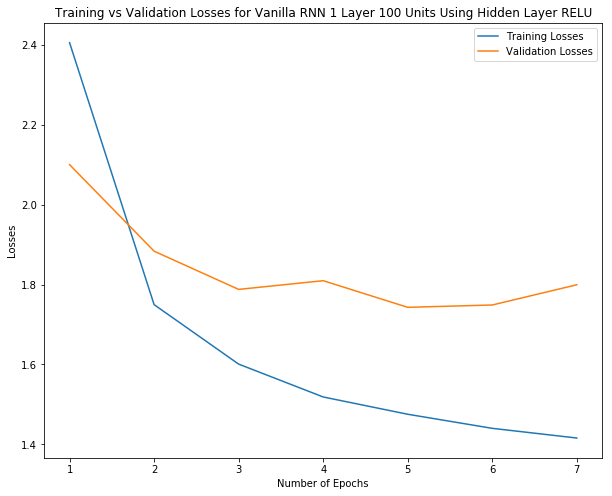

In [12]:
tloss, vloss

graph_title = 'Training vs Validation Losses for Vanilla RNN 1 Layer 100 Units Using Hidden Layer RELU'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(tloss) + 1), tloss, label='Training Losses')
ax.plot(np.arange(1, len(vloss) + 1), vloss, label='Validation Losses')
ax.set(xlabel='Number of Epochs', ylabel='Losses',
           title=graph_title)
leg = ax.legend() #loc=4)
fig.savefig('vanilla_rnn_losses_relu.png')

In [13]:
prime_chars = open('prime.txt').read()
prime_chars

'<start>\nX:1\nT:Contredanse\nO:Fr'

In [14]:
lowest_vloss = np.argmin(vloss)
best_model = models[lowest_vloss] #get the state_dict of the model at the lowest validation loss point

torch.save(best_model, 'best_model_rnn.pt') # save state_dict incase next part doesnt work?

In [15]:
bestmodelpath = 'best_model_rnn.pt'

makesong_net = RNnet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, weight)

makesong_net.load_state_dict(torch.load(bestmodelpath))
makesong_net = makesong_net.to(device)
makesong_net.eval()

RNnet(
  (char_embeddings): Embedding(94, 94)
  (rnn): RNN(94, 100)
  (hidden2out): Linear(in_features=100, out_features=94, bias=True)
)

In [17]:
input_char = '<' # make longer if not doing it right '<start>'
input_string = '<start>\nX:'
temp = 0.5
inp_str = prime_chars

inputs = prepare(inp_str).to(device)
initial_output = makesong_net(inputs, None)

pls_work = torch.multinomial(F.softmax(initial_output.div(temp)), 1)
lastchar = to_char(pls_work[-1])

inp_str += lastchar
print(inp_str)
print()

# argmax
# multiple
while '<end>' not in inp_str:
# for _ in range(1000):
    inputs = prepare(inp_str).to(device)
    output = makesong_net(inputs, None)
    pls_work = torch.multinomial(F.softmax(output.div(temp)), 1)
    lastchar = to_char(pls_work[-1])
    inp_str += lastchar
    
    print(inp_str)
    if 'λ' in inp_str:
        break

print(inp_str)

<start>
X:1
T:Contredanse
O:Fra

<start>
X:1
T:Contredanse
O:Fran
<start>
X:1
T:Contredanse
O:Franc
<start>
X:1
T:Contredanse
O:France
<start>
X:1
T:Contredanse
O:France

<start>
X:1
T:Contredanse
O:France
A
<start>
X:1
T:Contredanse
O:France
A:
<start>
X:1
T:Contredanse
O:France
A:P
<start>
X:1
T:Contredanse
O:France
A:Pr
<start>
X:1
T:Contredanse
O:France
A:Pro
<start>
X:1
T:Contredanse
O:France
A:Prov
<start>
X:1
T:Contredanse
O:France
A:Prove
<start>
X:1
T:Contredanse
O:France
A:Proven
<start>
X:1
T:Contredanse
O:France
A:Provenc
<start>
X:1
T:Contredanse
O:France
A:Provence
<start>
X:1
T:Contredanse
O:France
A:Provence

<start>
X:1
T:Contredanse
O:France
A:Provence
C
<start>
X:1
T:Contredanse
O:France
A:Provence
C:
<start>
X:1
T:Contredanse
O:France
A:Provence
C:T
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Tr
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Tra
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
<start>
X:

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:B
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpi
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpip
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ba

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corri
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig?
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers ba

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 |
<start>
X:

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) 
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) f
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D


<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/)
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Mag

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/)
<start>
X:1
T

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|B

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | 
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/)

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | 
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Mich

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ 
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Br

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 |
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Boll

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG 
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lo

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:Fr
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gorta

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel B
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ 
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur


<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f
<start>
X:1
T:Contredanse
O:France
A:Provence
C:Tr

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B
<start>
X:1
T:Contredanse
O:Fra

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c
<start>
X:1


<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 

In [19]:
print(inp_str)

<start>
X:1
T:Contredanse
O:France
A:Provence
C:Trad.
R:Ball Aloutine Grin Guran er Magur
C:Trad.
A:S.
Z:id:hn-1738)
Z:id:hn-portp Horeet
R:Ballan Bers bar
M:C|
K:D
V:1 Gortan
R:Ball de doubs ? lonnes
R:arts the parsto
Z:id:hn-pornpipe
R:Bolle
C:Japle
Z:id:hn-192 Brot et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:G
DA G2 | B3 | d>d dc | df/2d/2 f/2/3/2 c/e/) f/2/) fa | g2 | e/2f/2 e/2d/2 d/2B/2 e/2A/2B/2 c/2e/2 e/2/)(d/B/A/G/ BA|BA BA|Bd c/|B/B/) d>B | d2 de | d2 B2 | B2 c>d | d/d/) (3B/B/B/) - | (d/2//2 d2 | fe/2d/2 | de/f/ dd|de f/2e/2c/2 e/2/f/d/ d/B/) dB/B/ dB | d2 cB/B/ | AG/2A/2 A3|GEA | d2 d2 | f3 | d2 de | c2 | c3- | d>d ed|ed ed/f/ | g2 | c2- | B2 | cB | BG/B/ | A2 (3ABA | BB/B/ dB/G/ BG | AB | dB/B/ | AB/d/ BA | B2BB | B2 Bd | c4 | B/d/e/2e/2 g/2e/2 e/2/3/2g/2 d/2 c/2 A2 | EG G2||
|:2et (1589)
O:France
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-15
M:C|
K:D
B/A/ | AB/B/ AB | c4 | B4 | B3/2B/2 c/2 c/2B/2 | de/f/ | (3c/d/ d/d/ | B2 | BAG | cd | B/2c/2 A/2G/2 E3 